In [1]:
import pandas as pd
import geopandas as gpd #allows for world map overlay

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import tkinter as tk
from tkinter import simpledialog, messagebox

import fsspec

In [2]:
# -------------------------------------------------------------------
# Things to adjust:
# need to make sure that all heatmaps can revert back to the selection screen
# maybe change the color of the oceans/water and ground (easier viewing)
# need to find a way to adjust the heatmap from data to display at the right size for the selection
# need to display the different overlap layers in different colors (as a genuine heatmap) with an accurate legend.
# need to add in the option to sort the data by date and display the heatmap as well.
# -------------------------------------------------------------------


In [3]:
# -------------------------------------------------------------------
# World Map Overlay
# -------------------------------------------------------------------
# Function to plot world map outline

url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/110m_cultural.zip"

def plot_world_map(ax):    
    with fsspec.open(f"simplecache::{url}") as file:
        world = gpd.read_file(file)
    #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

In [4]:
# -------------------------------------------------------------------
# Country Display function -- NEEDS WORK!
# -------------------------------------------------------------------

# Function to display a country on a world map
#this needs some adjustments and pieces so right now, it is listed as not implemented when hit on the dialog...
def display_country(country_name):
    with fsspec.open(f"simplecache::{url}") as file:
        world = gpd.read_file(file)
    #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    country = world[world['name'] == country_name]

    fig, ax = plt.subplots(figsize=(10, 8))
    world.plot(ax=ax, color='lightgrey')
    country.plot(ax=ax, color='blue')

    ax.set_title(country_name)
    plt.show()


In [5]:
# -------------------------------------------------------------------
# Heatmap Functions
# -------------------------------------------------------------------

# Heatmap() function for generating custom-colored heatmaps
#this is for the custom heatmaps
def Heatmaps(grid_size, min_lat, max_lat, min_lon, max_lon):
    # Read the larger CSV file with 800,000 data points
    df = pd.read_csv('coordinates_dates_2022.csv')

    # Filter data based on user-provided latitude and longitude range
    filtered_df = df[(df['coordinate1_lat'] >= min_lat) & (df['coordinate1_lat'] <= max_lat) &
                     (2*df['coordinate1_lon'] >= min_lon) & (2*df['coordinate1_lon'] <= max_lon)]

    # Process the filtered data to get a frequency map of coordinates
    coordinate_counts = filtered_df.groupby(['coordinate1_lat', 'coordinate1_lon']).size()

    # Create a higher resolution 2D grid for the heatmap
    heatmap_grid = np.zeros((grid_size, grid_size))

    # Fill the grid with frequency data from the filtered data
    for (lat, lon), count in coordinate_counts.items():
        x = int((lat + 180) / 360 * (grid_size - 1))
        y = int((lon + 90) / 360 * (grid_size - 1))
        x = max(0, min(x, grid_size - 1))
        y = max(0, min(2*y, grid_size - 1))
        heatmap_grid[x, y] = count

    # Normalize the grid for image intensity
    heatmap_grid_normalized = heatmap_grid / heatmap_grid.max()

    # Rotate the data using NumPy
    rotated_heatmap = np.rot90(heatmap_grid_normalized)

    # Define custom colors based on the number of data points
    colors = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']

    # Create a custom colormap
    custom_cmap = ListedColormap(colors)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Overlay world map outline
    plot_world_map(ax)

    # Plot the heatmap with custom colors
    img = ax.imshow(rotated_heatmap, cmap=custom_cmap, extent=[min_lat, max_lat, min_lon, max_lon])

    # Set axis labels
    ax.set_title('Requested Heatmap', fontsize=20, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)

    # Save and show the image
    plt.savefig('heatmap_OverMap.png')
    plt.show()


In [6]:
#NEED TO MAKE SURE THAT WHEN THIS FIGURE IS DONE, WE CAN EXIT THE PROGRAM!

# -------------------------------------------------------------------
# Full World Heatmap function
def full_world_heatmap():
    # Read the CSV file with coordinate data
    df = pd.read_csv('coordinates_dates_2022.csv')

    # Process the data to get a frequency map of coordinates
    coordinate_counts = df.groupby(['coordinate1_lat', 'coordinate1_lon']).size()

    # Create a higher resolution 2D grid for the heatmap
    grid_size = 250  # Increase grid size for more data points
    heatmap_grid = np.zeros((grid_size, grid_size))

    # Fill the grid with frequency data
    for (lat, lon), count in coordinate_counts.items():
        # Adjust rounding logic for coordinates along the border
        x = int((lat + 180) / 360 * (grid_size - 1))
        y = int((lon + 90) / 360 * (grid_size - 1))
        x = max(0, min(x, grid_size - 1))
        y = max(0, min(2*y, grid_size - 1))
        heatmap_grid[x, y] = count

    # Normalize the grid for image intensity
    heatmap_grid_normalized = heatmap_grid / heatmap_grid.max()

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the heatmap
    cmap = plt.cm.viridis 
    colored_heatmap = cmap(heatmap_grid_normalized)

    #rotate the data gathered
    rotated_heatmap = np.rot90(heatmap_grid_normalized)

    img = ax.imshow(rotated_heatmap, extent=[-180, 180, -90, 90])
   
    # Set title and axis labels
    ax.set_title("Full World Heatmap", fontsize=20, fontweight='bold')
    ax.set_xlabel("Lattitude", fontsize=16)
    ax.set_ylabel("Longitude", fontsize = 16)

    # Overlay world map outline
    plot_world_map(ax)

    # Save and show the image
    plt.savefig('heatmap_with_world_map.png')
    plt.show()

In [7]:
# -------------------------------------------------------------------
# User Interfacing Functions - Button Implements
# -------------------------------------------------------------------

# Function to handle the "Exit" button
def exit_program():
    root.destroy()  # Close the main window

# Function to handle the "Not Implemented" button
def not_implemented():
    messagebox.showinfo("Info", "This has yet to be implemented!")
    root.destroy()  # Close the main window

# -------------------------------------------------------------------
# User Infercaing Functions - Windows
# -------------------------------------------------------------------

# Function to create a custom dialog for selecting options
def choose_option_dialog():
    dialog = tk.Toplevel()
    dialog.title("ASF Heatmap Application")

    # Label
    label = tk.Label(dialog, text="Select an option:")
    label.pack(pady=10)

    # Button for Display Country on World Map
    btn_country = tk.Button(dialog, text="Display Country on World Map", command=not_implemented)
    btn_country.pack(pady=5) #lambda: display_country_dialog(dialog) is what was used in command above

    # Button for Generate Heatmap
    btn_heatmap = tk.Button(dialog, text="Generate Custom Heatmap", command=lambda: generate_heatmap_dialog(dialog))
    btn_heatmap.pack(pady=5)

    # Button for Full World Heatmap
    btn_full_world_heatmap = tk.Button(dialog, text="Full World Heatmap", command=lambda: full_world_heatmap())
    btn_full_world_heatmap.pack(pady=5)

    # Button for "Exit"
    btn_exit = tk.Button(dialog, text="Exit", command=exit_program)
    btn_exit.pack(pady=5)

# -------------------------------------------------------------------
# User Interfacing Functions - Heatmap generation with UI
# -------------------------------------------------------------------

# Function to handle the Display Country on World Map option
def display_country_dialog(dialog):
    dialog.destroy()
    country_name = simpledialog.askstring("Input", "Enter the country name:")
    if country_name:
        display_country(country_name)
    else:
        messagebox.showinfo("Info", "Invalid country name.")

# Function to handle the Generate Heatmap option
def generate_heatmap_dialog(dialog):
    dialog.destroy()
    grid_size = simpledialog.askinteger("Input", "Enter the grid size for the heatmap (e.g., 150):")
    min_lat = simpledialog.askfloat("Input", "Enter the minimum latitude:")
    max_lat = simpledialog.askfloat("Input", "Enter the maximum latitude:")
    min_lon = simpledialog.askfloat("Input", "Enter the minimum longitude:")
    max_lon = simpledialog.askfloat("Input", "Enter the maximum longitude:")
    Heatmaps(grid_size, min_lat, max_lat, min_lon, max_lon)

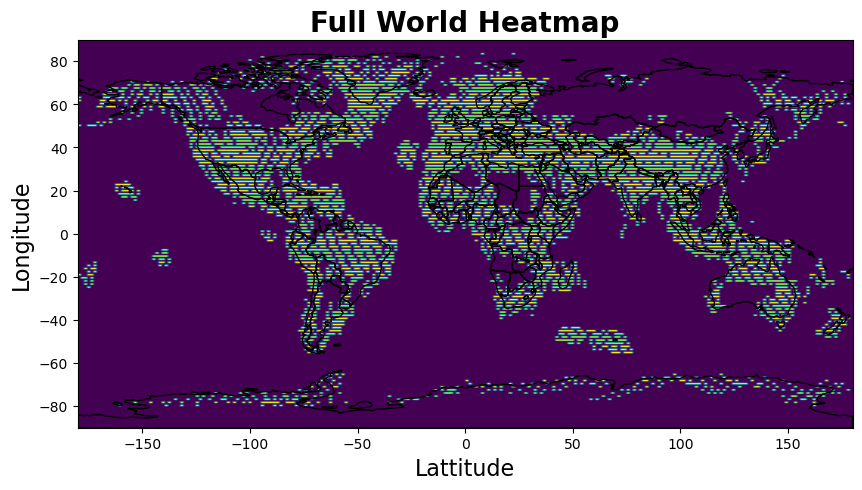

In [8]:
#NEED TO MAKE SURE THAT CUSTOM HEATMAP ALLOWS YOU TO GET BACK TO THE MAIN MENU OR EXITS THE PROGRAM ENTIRELY!!!

# -------------------------------------------------------------------
# Window Creation with Tkinter
# -------------------------------------------------------------------

# Create a Tkinter window for user input
root = tk.Tk()

# Hide the main window
root.withdraw()

# Call the function to choose the display option
choose_option_dialog()

# Start the Tkinter event loop
root.mainloop()